# Gaussian Kernel Density Estimation (method 01)

One of the methods used to calculate the density of particles is a 2-dimensional horizontal Gaussian Kernel Density Estimation (GKDE). This is a non-parametric (applicable to a non-Gaussian distribution) estimate of the probability density function of a field. 

In this example below, the GKDE is applied to a snapshot of particle positions, on all particles in the whole domain.

We use the python SciPy stats gaussian\_kde algorithm with a default kernel size (bandwidth), which is calculated following Scott's Rule <a href="https://onlinelibrary.wiley.com/doi/book/10.1002/9780470316849" target="_blank">[Scott, 1992]</a>. This bandwidth selector calculates the optimal bandwidth value that avoids both over-smoothing and under-smoothing.


* Author(s): Laura Gomez Navarro
* Created on: 11/11/22
* Last updated on:

In [1]:
import time

print(time.ctime(time.time()))

Wed Jun 28 16:04:39 2023


### 0.  Imports and package versions

In [2]:
from glob import glob
import xarray as xr
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import inspect
import sys

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, xarray, scipy

Software versions
Python 3.8.5 64bit [Clang 10.0.0 ]
IPython 7.20.0
OS macOS 10.16 x86_64 i386 64bit
numpy 1.19.2
xarray 0.16.2
scipy 1.6.0
Wed Jun 28 16:04:46 2023 CEST

### 1. Loading the data

In [5]:
filedir = '../Simulations/'

In [6]:
ds = xr.open_dataset(filedir + 'toy_data_01.nc')

In [7]:
ds

<xarray.Dataset>
Dimensions:     (obs: 121, traj: 144)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    U           (traj, obs) float32 ...
    V           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical

### 2. Calculating the GKDE

### 2.1. Loading the functions

In [8]:
sys.path.insert(0, filedir_root + "Lagrangian_diags/Diagnostics/Functions/")

In [9]:
import GKDE_01

In [10]:
print(inspect.getsource(GKDE_01))

import numpy as np
from scipy.stats import gaussian_kde

def rem_nans(ds):
    """
    This renders lon and lat variables without nans for the last timestep.
    """
    bad_indices = np.isnan(ds['lon'][:,-1]) | np.isnan(ds['lat'][:,-1])
    good_indices = ~bad_indices
    lon_end_nonans = ds['lon'][:,-1][good_indices]
    lat_end_nonans = ds['lat'][:,-1][good_indices]
    
    return lon_end_nonans, lat_end_nonans

def kde_vals(lon_end_nonans, lat_end_nonans):
    """
    Calculates the KDE values and sorts x (lon) and y (lat) in function of z (KDE)
    
    Inputs :
    - lon_end_nonans : Longitude values free of nans
    - lat_end_nonans : Latitude values free of nans
    
    Outputs: 
    - x : longitude values
    - y : latitude values
    - z : KDE values
    """
    x = lon_end_nonans.copy()
    y = lat_end_nonans.copy()
    
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    return x, y, z

def kde_parce

### 2.2. Applying the GKDE functions

In [11]:
kde_x, kde_y, kde_z = GKDE_01.kde_parcels(ds)


### 3. Plotting the outputs

### 3.1. Plotting cumulative distance evolution in time for the first 10 particle trajectories

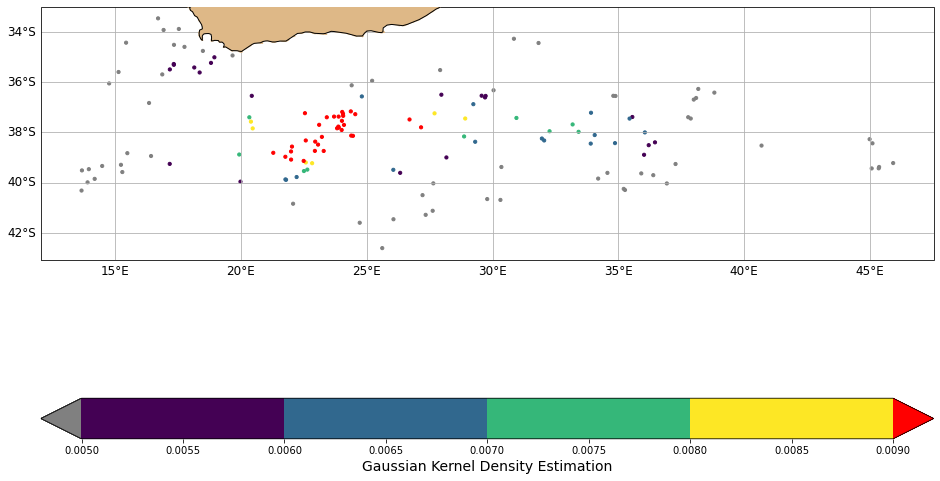

In [13]:
fig = plt.figure(figsize=(16,17)) #(17,5)

cbar_ticks = [0.005, 0.006, 0.007, 0.008, 0.009] 

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
    
#     ax1.set_xlim([-35.1, -18])
#     ax1.set_ylim([29.9, 40])

ss = ax1.scatter(kde_x, kde_y, c=kde_z, s=10, vmin=cbar_ticks[0], vmax=cbar_ticks[-1], cmap=plt.cm.get_cmap('viridis', len(cbar_ticks)-1), transform=ccrs.PlateCarree())
ss.cmap.set_over('r')
ss.cmap.set_under('gray')

ax1.coastlines(resolution='50m', color='black', linewidth=1, zorder=50)
ax1.add_feature(cartopy.feature.LAND, facecolor='burlywood', zorder=20) 
    
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([-42., -40., -38., -36., -34.])
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

cbar = plt.colorbar(ss, extend='both', orientation='horizontal')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_xlabel('Gaussian Kernel Density Estimation', size=14) #, rotation = 270

plt.show()


***--> in this test case the GKDE does not show so clearly the accumulation zones as more particles should be released in the region of study***

### 4. Quantification

A way to quantify then the above plot is to calculate the percentage of particles with a "high" GKDE value, that we choose it to be 0.008

* first check if any particles deleted:

In [17]:
ds['lon'][:,-1].values

array([26.698011, 28.164171, 27.643606, 24.718645, 37.995255, 29.234638,
       38.174526, 38.089085, 36.386173, 36.925137, 37.271023, 27.692135,
       34.057995, 33.911255, 36.052097, 27.156801, 37.874683, 25.212149,
       44.984165, 32.263596, 29.785528, 36.0202  , 33.17997 , 30.311327,
       23.818752, 25.614098, 24.09303 , 35.909134, 35.44305 , 24.450853,
       38.81421 , 31.958689, 34.563725, 33.417557, 33.89991 , 32.049088,
       21.763323, 14.18421 , 22.636242, 34.797607, 24.023075, 24.054976,
       31.82561 , 45.362434, 45.066288, 45.34612 , 35.21189 , 35.262207,
       26.059761, 15.283366, 24.001287, 22.936937, 22.500818, 24.380352,
       21.790487, 21.282694, 34.865032, 45.920753, 45.098103, 34.195713,
       22.949871, 13.661928, 27.963894, 23.287018, 23.10574 , 21.98923 ,
       24.398281, 29.69943 , 30.03786 , 28.911987, 35.554043, 36.454082,
       24.802662, 15.132946, 15.482158, 14.75911 , 22.573833, 23.885687,
       21.990768, 23.868902, 23.409975, 22.211067, 

* we calculate now the percentage of particles with a high GKDE value:

In [18]:
nondelp = sum(~np.isnan(ds['lon'][:,-1].data)) # calculating the total non-nan particles (none present in this 
                                               # test case , but there could be some particles that values are
                                               # nan due to for example boundary conditions)

perc_high = np.round(((np.count_nonzero(kde_z >= 0.008)) / nondelp) * 100, 2)
perc_high

26.39